In [96]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Parameters
# W = 100          # Number of pulse windows
# T = 60           # Total pulse duration (arbitrary time units)
# ΔΩ = 0.5         # Maximum amplitude range [-ΔΩ, +ΔΩ]
# n_qubits = 2     # Number of independent control channels

# # Generate random amplitudes for each window (shape: [W, n_qubits])
# np.random.seed(0)  
# amplitudes = ΔΩ * (2 * np.random.rand(W, n_qubits) - 1)

# # Create time axis with W+1 points for square pulse edges
# time_points = np.linspace(0, T, W+1)

# # Plot square pulses
# plt.figure(figsize=(10, 4))
# for q in range(n_qubits):
#     # Plot and get the StepPlot object
#     step_obj = plt.step(time_points, 
#                         np.append(amplitudes[:, q], amplitudes[-1, q]), 
#                         where='post', 
#                         label=f'Qubit {q+1}')
#     # Extract what matplotlib actually plotted
#     x = step_obj[0].get_xdata()
#     y = step_obj[0].get_ydata()
#     # Save the plotted step data
#     np.savetxt(f"square_pulse_qubit{q+1}.csv",
#                np.column_stack([x, y]),
#                delimiter=",",
#                header="time,amplitude",
#                comments='')


# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.title(f'Square Pulses ({W} Windows) with Random Amplitudes')
# plt.legend()
# plt.grid(True)
# plt.show()


In [97]:
using Plots
using LinearAlgebra
using FFTW

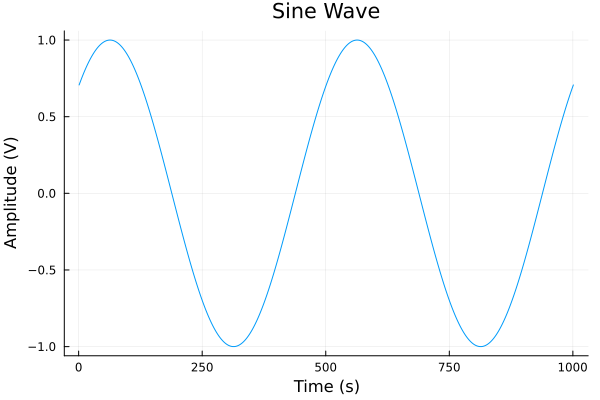

In [98]:

struct DigitizedSignal{T}
    samples::Vector{T}
    δt::Float64
    carrier_freq::Float64
end
"""
    Sinusoidal{T<:AbstractFloat}
Continuous sine wave representation.

# Fields
- `amplitude::T`: Peak amplitude (V)
- `frequency::T`: Frequency (Hz)
- `phase::T`: Phase offset (radians)

# Example
	Sinusoidal(1.0, 1e6, π/4)  # 1MHz sine wave with 45° phase
"""
struct Sinusoidal{T<:AbstractFloat}
    amplitude::T
    frequency::T
    phase::T
end
function to_digitized(s::Sinusoidal, δt::Float64, duration::Float64)
    t = 0:δt:duration
    samples = s.amplitude .* sin.(2π*s.frequency*t .+ s.phase)
    return DigitizedSignal(samples, δt, s.frequency)
end

function analyze_sinusoidal(samples, δt)
    N = length(samples)
    fft_result = fft(samples)
    freq_bins = fftshift(fftfreq(N, δt))
    fft_mags = abs.(fftshift(fft_result))
    peak_idx = argmax(fft_mags)
    freq = abs(freq_bins[peak_idx])
    amplitude = (maximum(samples) - minimum(samples)) / 2
    return amplitude, freq
end

Sinusoidal(1.0, 10.0, π/4)
plot_sinusoidal(s::Sinusoidal{T}, t::AbstractVector{T}) where T<:AbstractFloat =
    s.amplitude * sin.(2π * s.frequency * t .+ s.phase)
plot(plot_sinusoidal(Sinusoidal(1.0, 2000.0, π/4), 0:1e-6:1e-3),
     xlabel="Time (s)", ylabel="Amplitude (V)",
     title="Sine Wave", legend=false)

In [99]:
using Printf
s = Sinusoidal(1.0, 1000.0, π/4)
δt = 1e-6
total_time = 1.0
samples = to_digitized(s, δt, total_time)
amplitude, freq = analyze_sinusoidal(samples.samples, δt)
@printf "Estimated amplitude: %.3f\nEstimated frequency: %.1f Hz\n" amplitude freq


Estimated amplitude: 1.000
Estimated frequency: 0.0 Hz


In [100]:

using Statistics

struct WindowedSquareWave{T<:AbstractFloat}
    frequency::T
    duty_cycle::T
    window_amplitudes::Vector{T}  # Amplitude for each window
    window_durations::Vector{T}   # Duration of each window (seconds)
    cumulative_times::Vector{T}   # Precomputed window boundaries
end

function WindowedSquareWave(frequency, duty_cycle, window_amplitudes, window_durations)
    cumulative_times = cumsum([0.0; window_durations])
    T = promote_type(typeof(frequency), typeof(duty_cycle), eltype(window_amplitudes), eltype(window_durations))
    WindowedSquareWave{T}(frequency, duty_cycle, window_amplitudes, window_durations, cumulative_times)
end

function value_at(sw::WindowedSquareWave{T}, t::T) where T<:AbstractFloat
    # Find which window contains 't'
    window_idx = searchsortedlast(sw.cumulative_times, t)
    amplitude = window_idx > length(sw.window_amplitudes) ? 0.0 : sw.window_amplitudes[window_idx]
    
    # Generate square wave for current window
    period = 1/sw.frequency
    phase = mod(t, period)
    return phase < sw.duty_cycle * period ? amplitude : zero(T)
end


value_at (generic function with 2 methods)

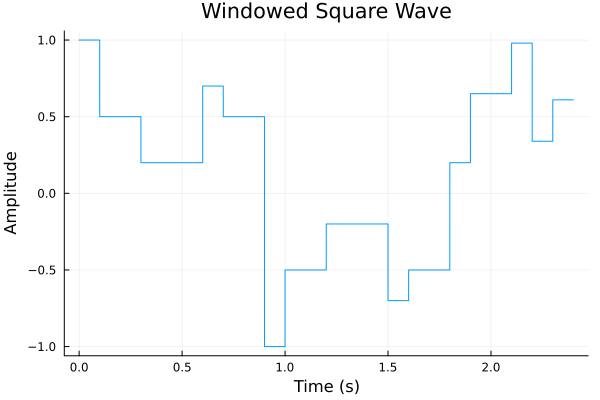

In [171]:
#  3 windows with different amplitudes
sw = WindowedSquareWave(
    100.0,            # 100Hz frequency
    1.0,              # 50% duty cycle
    [1.0, 0.5, 0.2,0.7,0.5,-1.0, -0.5, -0.2,-0.7,-0.5,0.2,0.65,0.98,0.34,0.61,0.43],  # Window amplitudes
    [0.1, 0.2, 0.3,0.1,0.2,0.1, 0.2, 0.3,0.1,0.2,0.1,0.2,0.1,0.1,0.1]   # Window durations (seconds)
)

# Generate samples
δt = 1e-4  # 0.1ms sampling interval
total_time = sum(sw.window_durations)
t = 0:δt:total_time
samples = [value_at(sw, τ) for τ in t]

# Plot first 0.5 seconds
using Plots
plot(t, samples, 
     xlabel="Time (s)", ylabel="Amplitude", 
     title="Windowed Square Wave", legend=false)


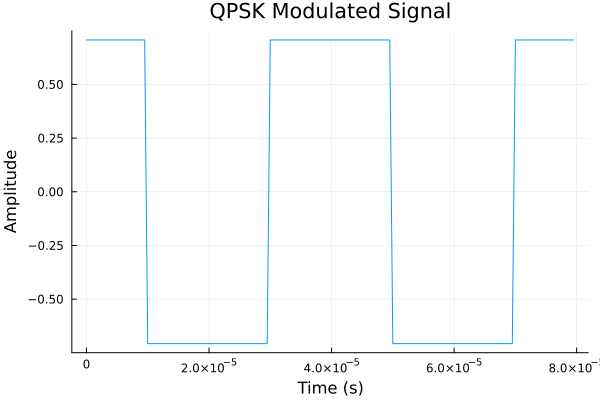

In [185]:
using Statistics

# Abstract signal for consistency
abstract type AbstractSignal end

# Quadrature Phase Shift Keying (QPSK) signal structure
struct QPSk{T<:AbstractFloat}
    carrier_freq::T
    symbol_rate::T
    phase_table::Vector{T}
    
    # Inner constructor with validation
    function QPSk{T}(carrier_freq::T, symbol_rate::T, phase_table::Vector{T}) where T
        @assert length(phase_table) == 4 "Phase table must contain exactly 4 elements"
        new(carrier_freq, symbol_rate, phase_table)
    end
end

# Outer constructor with Gray-coded default mapping
QPSk(carrier_freq::T, symbol_rate::T) where {T<:AbstractFloat} = QPsk{T}(
    carrier_freq, symbol_rate, T[π/4, 3π/4, 5π/4, 7π/4]
)

"""
    generate_qpsk(qpsk::QPsk, symbols::Vector{Int}, δt::T)

Generate modulated QPSK signal from given symbol sequence.
"""
function generate_qpsk(qpsk::QPSk{T}, symbols::Vector{Int}, δt::T) where T<:AbstractFloat
    # Ensure symbol indices are valid (1-based indexing for Julia)
    @assert all(1 ≤ s ≤ 4 for s in symbols) "Symbols must be in range 1–4"
    
    samples_per_symbol = round(Int, 1 / (qpsk.symbol_rate * δt))

    # Map symbols to I/Q values
    i_vals = [cos(qpsk.phase_table[s]) for s in symbols]
    q_vals = [sin(qpsk.phase_table[s]) for s in symbols]

    # Apply rectangular pulse shaping
    i_pulse = repeat(i_vals, inner=samples_per_symbol)
    q_pulse = repeat(q_vals, inner=samples_per_symbol)

    # Time array
    t = range(zero(T), step=δt, length=length(i_pulse))

    # Carrier signals
    i_carrier = cos.(2π * qpsk.carrier_freq .* t)
    q_carrier = sin.(2π * qpsk.carrier_freq .* t)

    # QPSK signal: modulated baseband components
    modulated = i_pulse .* i_carrier .+ q_pulse .* q_carrier

    return DigitizedSignal(modulated, δt, qpsk.carrier_freq)
end

# QPSK parameters
qpsk = QPSk(2e6, 1e5)  # 2 MHz carrier, 100 k symbols/sec
δt = 5e-7      # 10 ns time resolution

# Define symbol stream (example: Gray-coded values)
symbol_sequence = [1, 2, 3, 4, 1, 3, 2, 4]  # Values from 1 to 4

# Generate signal
qpsk_signal = generate_qpsk(qpsk, symbol_sequence, δt)

# ---------- Plotting ----------
using Plots
times = (0:length(qpsk_signal.samples)-1) .* qpsk_signal.δt
plot(times, qpsk_signal.samples, xlabel="Time (s)", ylabel="Amplitude",
     title="QPSK Modulated Signal", legend=false)


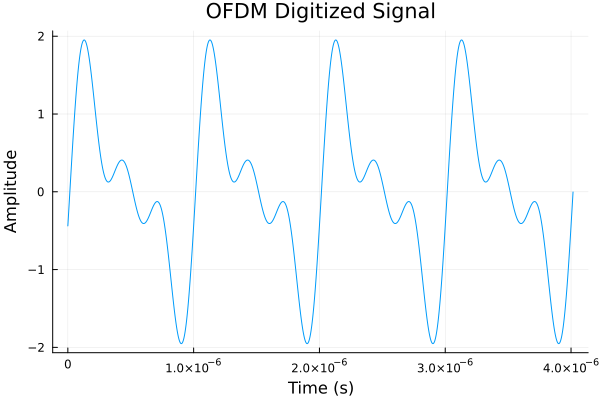

In [180]:
using Statistics

abstract type AbstractSignal end

# Sinusoidal signal definition
struct SinuSoidal{T<:AbstractFloat} <: AbstractSignal
    amplitude::T
    frequency::T
    phase::T
end

function value_at(sig::SinuSoidal{T}, t::T) where T
    sig.amplitude * sin(2π * sig.frequency * t + sig.phase)
end



"""
    to_digitized(sig::Sinusoidal, Δt, n_samples)

Generate digitized sinusoidal signal for a fixed number of samples.
"""
function to_digitized(sig::SinuSoidal{T}, Δt::T, n_samples::Int) where T
    times = (0:n_samples-1) .* Δt
    samples = [value_at(sig, t) for t in times]
    return DigitizedSignal(samples, Δt, sig.frequency)
end

# OFDM signal structure
struct OFDMSIGNAL{T<:AbstractFloat}
    subcarriers::Vector{SinuSoidal{T}}
    cyclic_prefix::T
    symbol_duration::T
end

"""
    to_digitized(ofdm::OFDMsignal, Δt)

Generate digitized OFDM symbol with cyclic prefix.
"""
function to_digitized(ofdm::OFDMSIGNAL{T}, Δt::T) where T
    Δf = 1 / ofdm.symbol_duration
    frequencies = [sc.frequency for sc in ofdm.subcarriers]
    @assert all(rem.(frequencies ./ Δf, 1) .< eps(T)) "Subcarriers must be integer multiples of 1/symbol_duration"

    n_samples = round(Int, ofdm.symbol_duration / Δt)
    symbol = zeros(T, n_samples)

    for sc in ofdm.subcarriers
        sc_sig = to_digitized(sc, Δt, n_samples)
        symbol .+= sc_sig.samples
    end

    cp_length = round(Int, ofdm.cyclic_prefix / Δt)
    cp = symbol[end - cp_length + 1:end]
    full_signal = [cp; symbol]

    return DigitizedSignal(full_signal, Δt, mean(frequencies))
end

# Example
subcarriers = [
    SinuSoidal(1.0, 1e6, 0.0),
    SinuSoidal(0.8, 2e6, 0.0),
    SinuSoidal(0.6, 3e6, 0.0)
]
ofdm = OFDMSIGNAL(subcarriers, 16e-9, 4e-6)
dig_signal = to_digitized(ofdm, 0.1e-9)

using Plots
plot(0:dig_signal.δt:(length(dig_signal.samples)-1)*dig_signal.δt, dig_signal.samples,
     xlabel = "Time (s)", ylabel = "Amplitude",
     title = "OFDM Digitized Signal", legend = false)


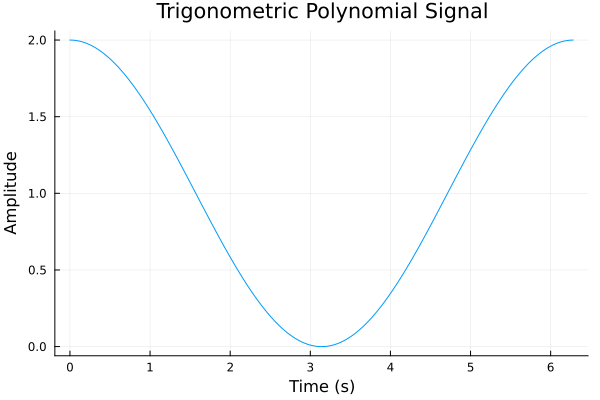

In [121]:
## 1. Trigonometric Signals (TrigPolys.jl approach)
"""
    TrigPolySignal{T<:AbstractFloat}
Trigonometric polynomial signal using FFT-based representation.

# Fields
- `coeffs::Vector{Complex{T}}`: Fourier coefficients
- `period::T`: Signal period (default 2π)
"""
struct TrigPolySignal{T<:AbstractFloat}
    coeffs::Vector{Complex{T}}
    period::T
end

function value_at(sig::TrigPolySignal, t::T) where T
    N = length(sig.coeffs)
    sum = zero(Complex{T})
    for (n,c) in enumerate(sig.coeffs)
        k = n - (N+1)÷2
        sum += c * exp(2π*im*k*t/sig.period)
    end
    return sum
end
# Example: 3-term Fourier series
coeffs = [0.5, 1.0+0im, 0.5]
trig_sig = TrigPolySignal(coeffs, 2π)
plot(t -> real(value_at(trig_sig, t)), 0:0.01:2π,
     xlabel="Time (s)", ylabel="Amplitude",
     title="Trigonometric Polynomial Signal", legend=false)

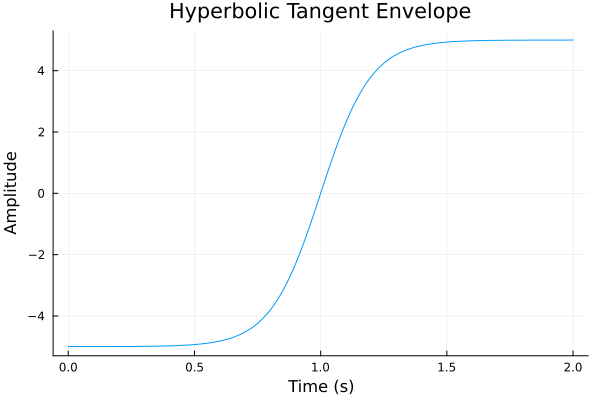

In [122]:
## 2. Hyperbolic Tangent Signal
"""
    TanhEnvelope{T<:AbstractFloat}
Signal with hyperbolic tangent envelope for smooth transitions.

# Fields
- `amplitude::T`: Peak amplitude
- `sigma::T`: Rise/fall time constant
- `center::T`: Central time position
"""
struct TanhEnvelope{T<:AbstractFloat}
    amplitude::T
    sigma::T
    center::T
end

function value_at(sig::TanhEnvelope, t::T) where T
    return sig.amplitude * tanh((t - sig.center)/sig.sigma)
end

# Example: Smooth step transition
tanh_sig = TanhEnvelope(5.0, 0.2, 1.0)
plot(t -> value_at(tanh_sig, t), 0:0.01:2,
     xlabel="Time (s)", ylabel="Amplitude",
     title="Hyperbolic Tangent Envelope", legend=false) 


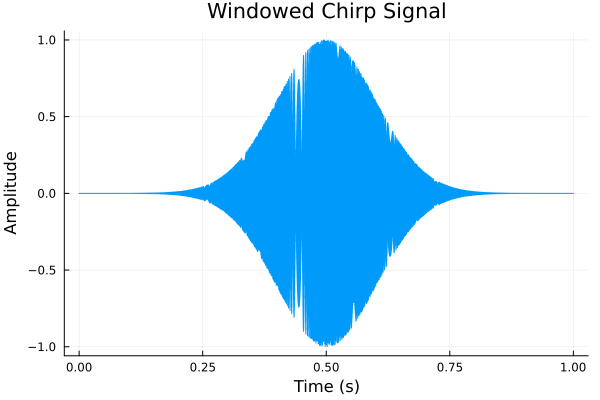

In [154]:
## 3. Windowed Composite Signal
"""
    WindowedSignal{T<:AbstractFloat}
Composite signal with time-windowed components.

# Fields
- `windows::Vector{Tuple{Symbol,AbstractSignal}}`: (window_type, signal) pairs
- `transitions::Vector{T}`: Transition times between windows
"""

# Abstract type for signals
abstract type AbstractSignal end

# Chirp signal type
struct ChirpSignal{T<:AbstractFloat} <: AbstractSignal
    f0::T      # Start frequency (Hz)
    f1::T      # End frequency (Hz)
    duration::T
end

# Chirp signal evaluation
function value_at(sig::ChirpSignal{T}, t::T) where T
    t_clamped = clamp(t, 0, sig.duration)
    k = (sig.f1 - sig.f0) / sig.duration
    phase = 2π * (sig.f0 * t_clamped + 0.5 * k * t_clamped^2)
    return sin(phase)
end

# Minimal window function implementation
function window_function(win_type::Symbol, t)
    win_type == :gaussian ? exp(-((t-0.5)^2)/(2*0.1^2)) : 1.0
end

struct Windowedsignal{T<:AbstractFloat}
    windows::Vector{Tuple{Symbol,ChirpSignal{T}}}
    transitions::Vector{T}
end

function value_at(sig::WindowedSignal{T}, t::T) where T
    t_clamped = clamp(t, sig.transitions[1], sig.transitions[end] - eps(T))
    idx = findlast(x -> t_clamped >= x, sig.transitions)
    win_type, component = sig.windows[idx]
    return window_function(win_type, t_clamped) * value_at(component, t_clamped)
end

# Example: Gaussian windowed chirp
chirp = ChirpSignal(1e3, 1e4, 1.0)  # 1kHz → 10kHz over 1s
windows = [(:gaussian, chirp)]
transitions = [0.0, 1.0]  # 2 transitions → 1 window
windowed_sig = Windowedsignal(windows, transitions)

ts = range(0, 0.9999999999, length=10000)
# value_at(windowed_sig, 0.8)
# value_at(windowed_sig, 0.5)
# value_at(windowed_sig, 0.98)
sample = zeros(length(ts))
for i in 1:length(ts)
    sample[i] = value_at(windowed_sig, ts[i])
end
plot(ts, sample, 
     xlabel="Time (s)", ylabel="Amplitude", 
     title="Windowed Chirp Signal", legend=false)

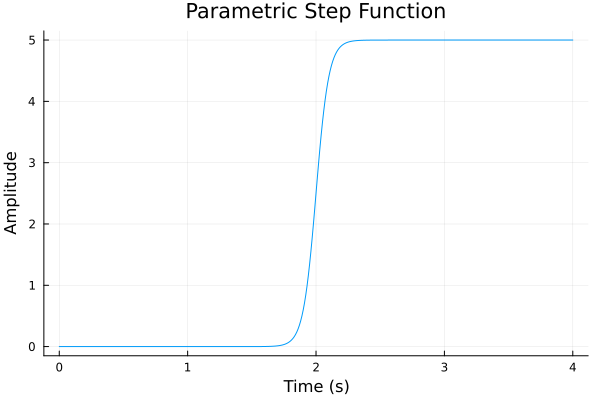

In [156]:
## 4. Parametric Step Function
"""
    ParamStep{T<:AbstractFloat}
Parametric step function with adjustable transition.

# Fields
- `amplitude::T`: Step height
- `position::T`: Step center position
- `width::T`: Transition width
"""
struct ParamStep{T<:AbstractFloat}
    amplitude::T
    position::T
    width::T
end

function value_at(sig::ParamStep, t::T) where T
    return sig.amplitude * 0.5*(tanh((t - sig.position)/sig.width) + 1)
end

# Example: Smooth step with 0.1s transition
step_sig = ParamStep(5.0, 2.0, 0.1)
plot(t -> value_at(step_sig, t), 0:0.01:4,
     xlabel="Time (s)", ylabel="Amplitude",
     title="Parametric Step Function", legend=false)

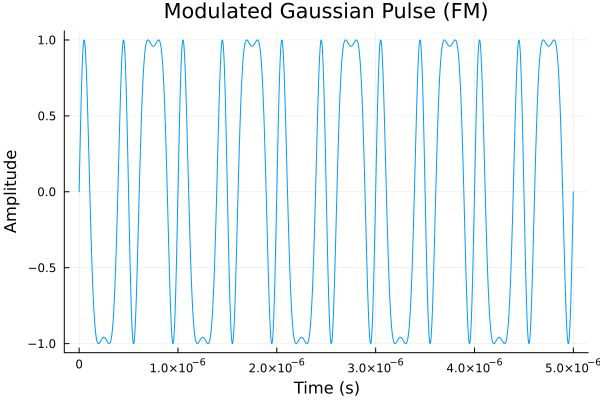

In [162]:
"""
    ModGaussian{T<:AbstractFloat}
Gaussian pulse with frequency modulation (FM).

# Fields
- `A::T`: Peak amplitude
- `σ::T`: Pulse width (standard deviation)
- `fc::T`: Carrier (center) frequency in Hz
- `fm::T`: Modulation frequency in Hz
- `β::T`: Modulation index (depth of frequency modulation)
"""
struct MODGaussian{T<:AbstractFloat}
    A::T
    σ::T
    fc::T
    fm::T
    β::T
end

function value_at(sig::MODGaussian, t::T) where T
    envelope = sig.A * exp(-t^2 / (2 * sig.σ^2))
    phase_mod = 2π * sig.fc * t + sig.β * sin(2π * sig.fm * t)
    carrier = sin(phase_mod)
    return envelope * carrier
end

modgauss_sig = MODGaussian(1.0, 0.001, 1e9, 1e6, 5.0)
plot(t -> value_at(modgauss_sig, t), 0:1e-9:5e-6,
     xlabel = "Time (s)", ylabel = "Amplitude",
     title = "Modulated Gaussian Pulse (FM)", legend = false)


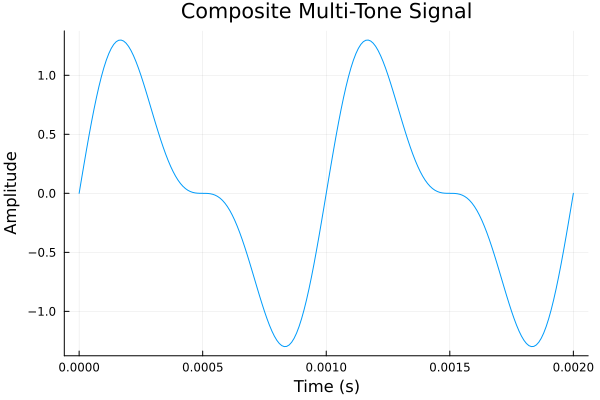

In [165]:
# Base signal interface
abstract type AbstractSignal end

"""
    Sine{T<:AbstractFloat}
A simple sine wave signal.

# Fields
- `A::T`: Amplitude
- `f::T`: Frequency (Hz)
- `ϕ::T`: Phase (optional, default = 0)
"""
struct Sine{T<:AbstractFloat} <: AbstractSignal
    A::T
    f::T
    ϕ::T
end

# Constructor without phase (defaults to 0)
Sine(A::T, f::T) where {T<:AbstractFloat} = Sine{T}(A, f, zero(T))

# Value of sine wave at time t
function value_at(sig::Sine, t::T) where T
    return sig.A * sin(2π * sig.f * t + sig.ϕ)
end

"""
    SignalSum{T<:AbstractFloat}
Algebraic sum of multiple signal components.
"""
struct SignalSUM <: AbstractSignal
    components::Vector{AbstractSignal}
end


function value_at(sig::SignalSUM, t::T) where T
    return sum(value_at(c, t) for c in sig.components)
end


sum_sig = SignalSUM([Sine(1.0, 1e3), Sine(0.5, 2e3)])
plot(t -> value_at(sum_sig, t), 0:1e-5:2e-3,
     xlabel = "Time (s)", ylabel = "Amplitude",
     title = "Composite Multi-Tone Signal", legend = false)


In [166]:
abstract type AbstractSignal end

"""
    ParametricSignal{P, R} <: AbstractSignal

A generic signal container parameterized by:
- `P`: Parameter type (e.g., NamedTuple, Dict, Struct)
- `R`: Return type (e.g., `Float64`, `ComplexF64`)
"""
struct ParametricSignal{P, R} <: AbstractSignal
    params::P
    eval_fn::Function  # Should be (params, t) -> R
end

# Signal evaluation at time t
function value_at(sig::ParametricSignal{P,R}, t::T) where {P, R, T}
    return sig.eval_fn(sig.params, t)::R
end



value_at (generic function with 16 methods)

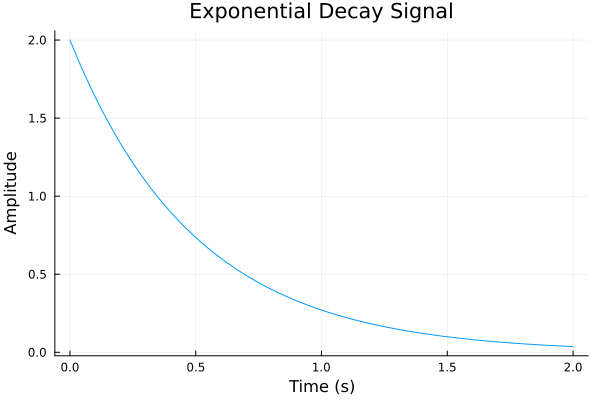

In [168]:
# Helper constructor with default return type
ParametricSignal(params::P, f::Function) where {P} = ParametricSignal{P, Float64}(params, f)

# Signal evaluation
function value_at(sig::ParametricSignal{P, R}, t::T) where {P, R, T}
    return sig.eval_fn(sig.params, t)::R
end

# Example usage
params = (A = 2.0, τ = 0.5)
exp_sig = ParametricSignal(params, (p, t) -> p.A * exp(-t / p.τ))

plot(t -> value_at(exp_sig, t), 0:0.01:2,
     xlabel = "Time (s)", ylabel = "Amplitude",
     title = "Exponential Decay Signal", legend = false)


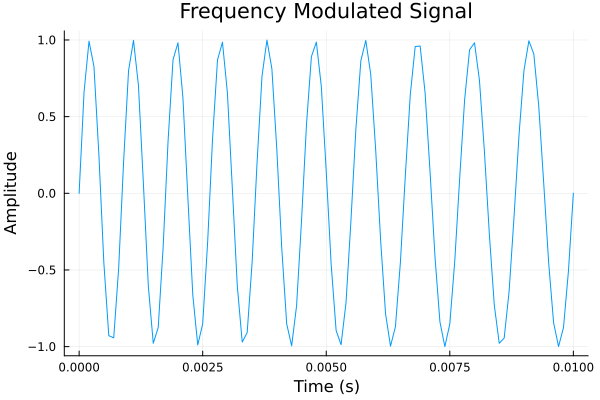

In [169]:
mod_params = (A = 1.0, fc = 1e3, fm = 50.0, β = 3.0)
mod_sig = ParametricSignal(mod_params, (p, t) -> 
    p.A * sin(2π * p.fc * t + p.β * sin(2π * p.fm * t))
)

plot(t -> value_at(mod_sig, t), 0:1e-4:0.01,
     xlabel = "Time (s)", ylabel = "Amplitude",
     title = "Frequency Modulated Signal", legend = false)


In [194]:
module SignalToolkit

using DSP
using Statistics
using LinearAlgebra

export Sinusoidal, DigitizedSignal, MultiChannelSignal
export samples, apply_filter, iq_downconvert, compute_spectrogram, estimate_evm, align_signals, resample

# === Data Types === #

struct Sinusoidal
    amplitude::Float64
    frequency::Float64
    phase::Float64
end

struct DigitizedSignal{T<:AbstractFloat}
    samples::Vector{T}
    δt::T
    carrier_freq::T
end

struct MultiChannelSignal
    channels::Vector{DigitizedSignal}
end


# === Signal Generation === #

"""
    samples(signal::Sinusoidal, δt::Float64, duration::Float64)
Generate time-domain samples from sinusoidal parameters.

Note: excludes endpoint for consistent sample count.
"""
function samples(signal::Sinusoidal, δt::Float64, duration::Float64)
    n_samples = floor(Int, duration / δt)
    t = range(0, step=δt, length=n_samples)
    return signal.amplitude .* sin.(2π .* signal.frequency .* t .+ signal.phase)
end


# === Signal Processing Utilities === #

"""
    apply_filter(signal::DigitizedSignal{T}, filter::Vector{Float64}) where T
Apply FIR filter to signal using convolution, maintaining original length.
"""
function apply_filter(signal::DigitizedSignal{T}, filter::Vector{Float64}) where T
    filtered = conv(signal.samples, filter)
    cropped = filtered[1:length(signal.samples)]
    return DigitizedSignal{T}(cropped, signal.δt, signal.carrier_freq)
end


"""
    iq_downconvert(signal::DigitizedSignal, lo_freq::Float64)
Perform IQ downconversion using digital mixer.

Note: Uses -sin() for Q channel for correct demodulation.
"""
function iq_downconvert(signal::DigitizedSignal, lo_freq::Float64)
    t = (0:length(signal.samples)-1) .* signal.δt
    I = signal.samples .* cos.(2π .* lo_freq .* t)
    Q = -signal.samples .* sin.(2π .* lo_freq .* t)
    return MultiChannelSignal([
        DigitizedSignal(I, signal.δt, 0.0),
        DigitizedSignal(Q, signal.δt, 0.0)
    ])
end


"""
    compute_spectrogram(signal::DigitizedSignal, window_size::Int)
Compute STFT magnitude spectrogram of signal.

Returns matrix with frequency bins as columns, time windows as rows.
"""
function compute_spectrogram(signal::DigitizedSignal, window_size::Int)
    stft = DSP.spectrogram(signal.samples, window=window_size, hop=window_size ÷ 2)
    return abs.(stft.power)
end


"""
    estimate_evm(ideal::DigitizedSignal, measured::DigitizedSignal)
Calculate RMS Error Vector Magnitude (%) between ideal and measured signals.
Returns evm_rms and aligned signals for plotting.
"""
function estimate_evm(ideal::DigitizedSignal, measured::DigitizedSignal)
    aligned = align_signals(ideal.samples, measured.samples)
    error = aligned.measured - aligned.ideal
    evm_rms = 100 * norm(error) / norm(aligned.ideal)
    return evm_rms, (ideal=aligned.ideal, measured=aligned.measured)
end


# === Helper Functions === #

"""
    align_signals(ref_sig::Vector, meas_sig::Vector)
Align measured signal to reference signal using cross-correlation.

Returns a NamedTuple of trimmed ideal and measured signals.
"""
function align_signals(ref_sig::Vector, meas_sig::Vector)
    corr = DSP.xcorr(meas_sig, ref_sig)
    lag = collect(-length(ref_sig)+1:length(meas_sig)-1)
    _, peak_idx = findmax(corr)
    offset = lag[peak_idx]

    if offset > 0
        aligned_meas = meas_sig[offset+1:end]
        aligned_ref = ref_sig[1:length(aligned_meas)]
    elseif offset < 0
        aligned_ref = ref_sig[-offset+1:end]
        aligned_meas = meas_sig[1:length(aligned_ref)]
    else
        len = min(length(ref_sig), length(meas_sig))
        aligned_ref = ref_sig[1:len]
        aligned_meas = meas_sig[1:len]
    end

    return (ideal = aligned_ref, measured = aligned_meas)
end


"""
    resample(symbols::Vector, samples_per_symbol::Int)
Nearest-neighbor resampling of symbol indices.
"""
function resample(symbols::Vector, samples_per_symbol::Int)
    return repeat(symbols, inner=samples_per_symbol)
end


end # module


Main.SignalToolkit

In [193]:
using Test
using DSP
using .SignalToolkit
using LinearAlgebra

# Create test sinusoid and digitized signals
sig = SignalToolkit.Sinusoidal(1.0, 1e3, 0.0)  # 1kHz sine
δt = 1e-4  # 0.1 ms sampling interval
duration = 0.01  # 10 ms duration

@testset "Samples function" begin
    s = SignalToolkit.samples(sig, δt, duration)
    @test length(s) == floor(Int, duration/δt)
    @test isapprox(mean(s), 0.0, atol=1e-2)
end

@testset "IQ Downconversion and alignment" begin
    samples = SignalToolkit.samples(sig, δt, duration)
    digsig = SignalToolkit.DigitizedSignal(samples, δt, sig.frequency)
    lo_freq = 1e3
    iq = SignalToolkit.iq_downconvert(digsig, lo_freq)

    @test length(iq.channels) == 2
    @test length(iq.channels[1].samples) == length(samples)
    @test length(iq.channels[2].samples) == length(samples)

    # Alignment test (identity)
    aligned = SignalToolkit.align_signals(samples, samples)
    @test length(aligned.ideal) == length(aligned.measured)
    @test all(aligned.ideal .== aligned.measured)
end

@testset "EVM estimation" begin
    # Introduce a small error to samples
    noisy_samples = samples .+ 0.01 .* randn(length(samples))
    ideal = SignalToolkit.DigitizedSignal(samples, δt, sig.frequency)
    measured = SignalToolkit.DigitizedSignal(noisy_samples, δt, sig.frequency)
    evm_rms, _ = SignalToolkit.estimate_evm(ideal, measured)

    @test evm_rms > 0
    @test evm_rms < 10  # Expected low error for small noise
end


Test Summary:    | Pass  Total
Samples function |    2      2
Test Summary:                   | Pass  Total
IQ Downconversion and alignment |    5      5
Test Summary:  | Pass  Total
EVM estimation |    2      2


Test.DefaultTestSet("EVM estimation", Any[], 2, false, false)